In [1]:
# This notebook accomplishes two objectives
# First it studies the uncertainty of irradiation forecasts as a function of time from
#     sunrise/sunset/either. It identifies the error both in terms of absolute and relative error
#     The results are plotted
#     No further statistical analysis on that data
# Second it studies the correlation between different solar irradiation parameters
#     It plots the absolute error of the three measurements of irradiation against each other
#     It calculates the pearson correlation coefficient and prints the results
# To accomplish this, the notebook calculates the error and relative error in every forecast
#     Forecasts must be stored in the folder specified by folder_forecasts
#     Several outputs are saved during the process
#         Each forecast is saved with the calculated errors added
#         Separate data frames are created storing the error for each hour from sunrise/sunset/either
#             Saved in the format [Sunrise, Sunset, Either]_Hour[#]
#         The stdev and mean error for each are stored in a statistics dataframe
#             One dataframe for error, a second for relative error
#             Thus two for each sunrise/sunset/either

import pandas as pd
import glob
import os
import sys
import datetime as dtm
import numpy as np
import suntime
import matplotlib.pyplot as plt
from IPython.display import display
import pvlib
import math

sys.path.append(r'C:\Users\Peter\Documents\Tools\btrdb_api')
from client import client as btrdb

path_colors = r'C:\Users\Peter\Documents\Tools\References'
sys.path.append(path_colors)
from LBL_Presentation_Colors import Colors

colors = {
          'ghi': Colors['Green'],
          'dni': Colors['Dark_Teal'],
          'dhi': Colors['Aqua']
}

latitude = 37.8788
longitude = -122.2501
suntimes = suntime.Sun(latitude, longitude)

cwd = os.getcwd()
print(cwd)

folder_forecasts = os.path.join(cwd, r'Data')
print(folder_forecasts)

forecasts = glob.glob(folder_forecasts + r'/*.csv')

first_forecast = pd.read_csv(forecasts[0], index_col = [0])
last_forecast = pd.read_csv(forecasts[-1], index_col = [0])

first_timestamp = pd.to_datetime(first_forecast.index[0]) - pd.Timedelta(hours = 1)
last_timestamp = last_forecast.index[-1]

print('first_timestamp is {}'.format(first_timestamp))
print('last_timestamp is {}'.format(last_timestamp))

C:\Users\Peter\Documents\MPC\ForecastAccuracy
C:\Users\Peter\Documents\MPC\ForecastAccuracy\Data
first_timestamp is 2021-05-19 21:00:00
last_timestamp is 2021-07-27 04:00:00


In [2]:
#Define function to gather data from database

def download_data(dt_start=dtm.datetime(2020,10,6,11,0),
                  dt_final=dtm.datetime.now()):
    # Download data
    #Specify specific exterior weather values to download
    channels = ['Exterior_we_Temperature_C','Exterior_we_GHI_W/m2','Exterior_we_DNI_W/m2','Exterior_we_DHI_W/m2']
    
    res = db.read_raw_db(dt_start, dt_final, channels)
    
    return res

In [3]:
#Log into database, download data, average hourly

db = btrdb()
db.login_no_interactive('device1', '123456')

monitored_data = download_data(dt_start = first_timestamp, dt_final = last_timestamp)

monitored_data = monitored_data.rename(columns={'Exterior_we_GHI_W/m2': 'ghi', 'Exterior_we_DNI_W/m2': 'dni',
                                        'Exterior_we_DHI_W/m2': 'dhi'})
monitored_data = monitored_data[['ghi', 'dni', 'dhi']]

hourly_mean = monitored_data.resample('H').mean()

print(hourly_mean.index)
print(hourly_mean.columns)

DatetimeIndex(['2021-05-19 21:00:00', '2021-05-19 22:00:00',
               '2021-05-19 23:00:00', '2021-05-20 00:00:00',
               '2021-05-20 01:00:00', '2021-05-20 02:00:00',
               '2021-05-20 03:00:00', '2021-05-20 04:00:00',
               '2021-05-20 05:00:00', '2021-05-20 06:00:00',
               ...
               '2021-07-26 18:00:00', '2021-07-26 19:00:00',
               '2021-07-26 20:00:00', '2021-07-26 21:00:00',
               '2021-07-26 22:00:00', '2021-07-26 23:00:00',
               '2021-07-27 00:00:00', '2021-07-27 01:00:00',
               '2021-07-27 02:00:00', '2021-07-27 03:00:00'],
              dtype='datetime64[ns]', name='date_time', length=1639, freq='H')
Index(['ghi', 'dni', 'dhi'], dtype='object')


In [4]:
error_columns = ['error_ghi', 'error_dni', 'error_dhi', 'relative_error_ghi', 'relative_error_dni', 
                 'relative_error_dhi']

SR_Zero = pd.DataFrame(columns = error_columns)
SR_One = pd.DataFrame(columns = error_columns)
SR_Two = pd.DataFrame(columns = error_columns)
SR_Three = pd.DataFrame(columns = error_columns)
SR_Four = pd.DataFrame(columns = error_columns)
SR_Five = pd.DataFrame(columns = error_columns)
SR_Six = pd.DataFrame(columns = error_columns)
SR_Seven = pd.DataFrame(columns = error_columns)
SR_Eight = pd.DataFrame(columns = error_columns)
SR_Nine = pd.DataFrame(columns = error_columns)
SR_Ten = pd.DataFrame(columns = error_columns)
SR_Eleven = pd.DataFrame(columns = error_columns)
SR_Twelve = pd.DataFrame(columns = error_columns)
SR_Thirteen = pd.DataFrame(columns = error_columns)
SR_Fourteen = pd.DataFrame(columns = error_columns)
SR_Fifteen = pd.DataFrame(columns = error_columns)

Sunrise = [SR_Zero, SR_One, SR_Two, SR_Three, SR_Four, SR_Five, SR_Six, SR_Seven, SR_Eight, SR_Nine, 
           SR_Ten, SR_Eleven, SR_Twelve, SR_Thirteen, SR_Fourteen, SR_Fifteen]

SS_Zero = pd.DataFrame(columns = error_columns)
SS_One = pd.DataFrame(columns = error_columns)
SS_Two = pd.DataFrame(columns = error_columns)
SS_Three = pd.DataFrame(columns = error_columns)
SS_Four = pd.DataFrame(columns = error_columns)
SS_Five = pd.DataFrame(columns = error_columns)
SS_Six = pd.DataFrame(columns = error_columns)
SS_Seven = pd.DataFrame(columns = error_columns)
SS_Eight = pd.DataFrame(columns = error_columns)
SS_Nine = pd.DataFrame(columns = error_columns)
SS_Ten = pd.DataFrame(columns = error_columns)
SS_Eleven = pd.DataFrame(columns = error_columns)
SS_Twelve = pd.DataFrame(columns = error_columns)
SS_Thirteen = pd.DataFrame(columns = error_columns)
SS_Fourteen = pd.DataFrame(columns = error_columns)
SS_Fifteen = pd.DataFrame(columns = error_columns)

Sunset = [SS_Zero, SS_One, SS_Two, SS_Three, SS_Four, SS_Five, SS_Six, SS_Seven, SS_Eight, SS_Nine, 
           SS_Ten, SS_Eleven, SS_Twelve, SS_Thirteen, SS_Fourteen, SS_Fifteen]

Zero = pd.DataFrame(columns = error_columns)
One = pd.DataFrame(columns = error_columns)
Two = pd.DataFrame(columns = error_columns)
Three = pd.DataFrame(columns = error_columns)
Four = pd.DataFrame(columns = error_columns)
Five = pd.DataFrame(columns = error_columns)
Six = pd.DataFrame(columns = error_columns)
Seven = pd.DataFrame(columns = error_columns)
Eight = pd.DataFrame(columns = error_columns)
Nine = pd.DataFrame(columns = error_columns)
Ten = pd.DataFrame(columns = error_columns)
Eleven = pd.DataFrame(columns = error_columns)
Twelve = pd.DataFrame(columns = error_columns)
Thirteen = pd.DataFrame(columns = error_columns)
Fourteen = pd.DataFrame(columns = error_columns)
Fifteen = pd.DataFrame(columns = error_columns)

Either = [Zero, One, Two, Three, Four, Five, Six, Seven, Eight, Nine, 
           Ten, Eleven, Twelve, Thirteen, Fourteen, Fifteen]
full_data_set = pd.DataFrame(columns = error_columns)

In [5]:
for forecast in forecasts:
    
    filename = forecast.split('Data\\')[-1]
    print(filename)
    data = pd.read_csv(forecast, index_col = [0])
    date = pd.to_datetime(data.index[0].split(' ')[0])
    date_next = date + pd.Timedelta(days = 1)
    data.index = pd.to_datetime(data.index) - pd.Timedelta(hours=1)
    
    month = data.index[0].month
    day = data.index[0].day
    
    # DHI measurement was disconnected from July 12 to July 20. Do not process those data sets
    if month == 7:

        if (day >= 12) & (day <= 20):
            print('Skipping dataset for {}/{} - Bad DHI measurements'.format(month, day))
            continue     
    
    data = data[['ghi', 'dni', 'dhi']]

    sunrise = suntimes.get_sunrise_time(date).replace(tzinfo=dtm.timezone.utc).astimezone(tz=None).replace(tzinfo=None)
    sunrise_timestamp = dtm.datetime(date.year, date.month, date.day, sunrise.hour)
    sunset = suntimes.get_sunset_time(date).replace(tzinfo=dtm.timezone.utc).astimezone(tz=None).replace(tzinfo=None) + pd.Timedelta(days = 1)
    sunset_timestamp = dtm.datetime(date.year, date.month, date.day, sunset.hour)

    sunrise_next = suntimes.get_sunrise_time(date_next).replace(tzinfo=dtm.timezone.utc).astimezone(tz=None).replace(tzinfo=None)
    sunrise_next_timestamp = dtm.datetime(date_next.year, date_next.month, date_next.day, sunrise_next.hour)
    sunset_next = suntimes.get_sunset_time(date_next).replace(tzinfo=dtm.timezone.utc).astimezone(tz=None).replace(tzinfo=None)  + pd.Timedelta(days = 1)
    sunset_next_timestamp = dtm.datetime(date_next.year, date_next.month, date_next.day, sunset_next.hour)
    data = data[data['ghi'] > 10]
    
    if len(data.index) == 0:
        print('No daytime forecast data found, skipping to next dataset')
        continue
    
    measured = hourly_mean[data.index[0]:data.index[-1]]
    

    for parameter in data.columns:
    
        column = parameter + '_measured'
        data[column] = measured[parameter]
        column = 'error_' + parameter
        data[column] = data[parameter] - measured[parameter]
        column = 'relative_error_' + parameter
        data[column] = (data[parameter] - measured[parameter]) / data[parameter]
        data = data.replace([np.inf, -np.inf], np.nan)

    data['hours after sunrise'] = np.where(data.index.day == date.day, 
                                      ((data.index - sunrise_timestamp).total_seconds() / 3600).astype(int),
                                      ((data.index - sunrise_next_timestamp).total_seconds() / 3600).astype(int))
    data['hours before sunset'] = np.where(data.index.day == date.day, 
                                      ((sunset_timestamp - data.index).total_seconds() / 3600).astype(int),
                                      ((sunset_next_timestamp - data.index).total_seconds() / 3600).astype(int))
    data['hours from either'] = data[['hours after sunrise', 'hours before sunset']].min(axis=1)
    
    full_data_set = full_data_set.append(data[error_columns])
    
    path_forecast_output = os.path.join(cwd, 'Data\solar\modified_forecasts', filename)
    data.to_csv(path_forecast_output)

    for i in data.index:
        result = data.loc[i, ['error_ghi', 'error_dni', 'error_dhi', 'relative_error_ghi', 
                              'relative_error_dni', 'relative_error_dhi']]
    
        hour_sr = data.loc[i, 'hours after sunrise']
        Sunrise[hour_sr].loc[i] = result
    
        hour_ss = data.loc[i, 'hours before sunset']
        Sunset[hour_ss].loc[i] = result
    
        hour_either = data.loc[i, 'hours from either']
        Either[hour_either].loc[i] = result
    

Forecast_71T_20210519-2200.csv
Forecast_71T_20210519-2300.csv
Forecast_71T_20210520-0000.csv
Forecast_71T_20210520-0100.csv
Forecast_71T_20210520-0200.csv
Forecast_71T_20210520-0300.csv
Forecast_71T_20210520-0400.csv
Forecast_71T_20210520-0500.csv
Forecast_71T_20210520-0600.csv
Forecast_71T_20210520-0700.csv
Forecast_71T_20210520-0800.csv
Forecast_71T_20210520-0900.csv
Forecast_71T_20210520-1000.csv
Forecast_71T_20210520-1100.csv
Forecast_71T_20210520-1200.csv
Forecast_71T_20210520-1300.csv
Forecast_71T_20210520-1400.csv
Forecast_71T_20210520-1500.csv
Forecast_71T_20210520-1600.csv
Forecast_71T_20210520-1700.csv
Forecast_71T_20210520-1800.csv
Forecast_71T_20210520-1900.csv
Forecast_71T_20210520-2000.csv
Forecast_71T_20210520-2100.csv
Forecast_71T_20210520-2200.csv
Forecast_71T_20210520-2300.csv
Forecast_71T_20210521-0000.csv
Forecast_71T_20210521-0100.csv
Forecast_71T_20210521-0200.csv
Forecast_71T_20210521-0300.csv
Forecast_71T_20210521-0400.csv
Forecast_71T_20210521-0500.csv
Forecast

Forecast_71T_20210531-0400.csv
Forecast_71T_20210531-0500.csv
Forecast_71T_20210531-0600.csv
Forecast_71T_20210531-0700.csv
Forecast_71T_20210531-0800.csv
Forecast_71T_20210531-0900.csv
Forecast_71T_20210531-1000.csv
Forecast_71T_20210531-1100.csv
Forecast_71T_20210531-1200.csv
Forecast_71T_20210531-1300.csv
Forecast_71T_20210531-1400.csv
Forecast_71T_20210531-1500.csv
Forecast_71T_20210531-1600.csv
Forecast_71T_20210531-1700.csv
Forecast_71T_20210531-1800.csv
Forecast_71T_20210531-1900.csv
Forecast_71T_20210531-2000.csv
Forecast_71T_20210531-2100.csv
Forecast_71T_20210531-2200.csv
Forecast_71T_20210531-2300.csv
Forecast_71T_20210601-0000.csv
Forecast_71T_20210601-0100.csv
Forecast_71T_20210601-0200.csv
Forecast_71T_20210601-0300.csv
Forecast_71T_20210601-0400.csv
Forecast_71T_20210601-0500.csv
Forecast_71T_20210601-0600.csv
Forecast_71T_20210601-0700.csv
Forecast_71T_20210601-0800.csv
Forecast_71T_20210601-0900.csv
Forecast_71T_20210601-1000.csv
Forecast_71T_20210601-1100.csv
Forecast

Forecast_71T_20210611-0900.csv
Forecast_71T_20210611-1000.csv
Forecast_71T_20210611-1100.csv
Forecast_71T_20210611-1200.csv
Forecast_71T_20210611-1300.csv
Forecast_71T_20210611-1400.csv
Forecast_71T_20210611-1500.csv
Forecast_71T_20210611-1600.csv
Forecast_71T_20210611-1700.csv
Forecast_71T_20210611-1800.csv
Forecast_71T_20210611-1900.csv
Forecast_71T_20210611-2000.csv
Forecast_71T_20210611-2100.csv
Forecast_71T_20210611-2200.csv
Forecast_71T_20210611-2300.csv
Forecast_71T_20210612-0000.csv
Forecast_71T_20210612-0100.csv
Forecast_71T_20210612-0200.csv
Forecast_71T_20210612-0300.csv
Forecast_71T_20210612-0400.csv
Forecast_71T_20210612-0500.csv
Forecast_71T_20210612-0600.csv
Forecast_71T_20210612-0700.csv
Forecast_71T_20210612-0800.csv
Forecast_71T_20210612-0900.csv
Forecast_71T_20210612-1000.csv
Forecast_71T_20210612-1100.csv
Forecast_71T_20210612-1200.csv
Forecast_71T_20210612-1300.csv
Forecast_71T_20210612-1400.csv
Forecast_71T_20210612-1500.csv
Forecast_71T_20210612-1600.csv
Forecast

Forecast_71T_20210622-1700.csv
Forecast_71T_20210622-1800.csv
Forecast_71T_20210622-1900.csv
Forecast_71T_20210622-2000.csv
Forecast_71T_20210622-2100.csv
Forecast_71T_20210622-2200.csv
Forecast_71T_20210622-2300.csv
Forecast_71T_20210623-0000.csv
Forecast_71T_20210623-0100.csv
Forecast_71T_20210623-0200.csv
Forecast_71T_20210623-0300.csv
Forecast_71T_20210623-0400.csv
Forecast_71T_20210623-0500.csv
Forecast_71T_20210623-0600.csv
Forecast_71T_20210623-0700.csv
Forecast_71T_20210623-0800.csv
Forecast_71T_20210623-0900.csv
Forecast_71T_20210623-1000.csv
Forecast_71T_20210623-1100.csv
Forecast_71T_20210623-1200.csv
Forecast_71T_20210623-1300.csv
Forecast_71T_20210623-1400.csv
Forecast_71T_20210623-1500.csv
Forecast_71T_20210623-1600.csv
Forecast_71T_20210623-1700.csv
Forecast_71T_20210623-1800.csv
Forecast_71T_20210623-1900.csv
Forecast_71T_20210623-2000.csv
Forecast_71T_20210623-2100.csv
Forecast_71T_20210623-2200.csv
Forecast_71T_20210623-2300.csv
Forecast_71T_20210624-0000.csv
Forecast

Forecast_71T_20210703-1800.csv
Forecast_71T_20210703-1900.csv
Forecast_71T_20210703-2000.csv
Forecast_71T_20210703-2100.csv
Forecast_71T_20210703-2200.csv
Forecast_71T_20210703-2300.csv
Forecast_71T_20210704-0000.csv
Forecast_71T_20210704-0100.csv
Forecast_71T_20210704-0200.csv
Forecast_71T_20210704-0300.csv
Forecast_71T_20210704-0400.csv
Forecast_71T_20210704-0500.csv
Forecast_71T_20210704-0600.csv
Forecast_71T_20210704-0700.csv
Forecast_71T_20210704-0800.csv
Forecast_71T_20210704-0900.csv
Forecast_71T_20210704-1000.csv
Forecast_71T_20210704-1100.csv
Forecast_71T_20210704-1200.csv
Forecast_71T_20210704-1300.csv
Forecast_71T_20210704-1400.csv
Forecast_71T_20210704-1500.csv
Forecast_71T_20210704-1600.csv
Forecast_71T_20210704-1700.csv
Forecast_71T_20210704-1800.csv
Forecast_71T_20210704-1900.csv
Forecast_71T_20210704-2000.csv
Forecast_71T_20210704-2100.csv
Forecast_71T_20210704-2200.csv
Forecast_71T_20210704-2300.csv
Forecast_71T_20210705-0000.csv
Forecast_71T_20210705-0100.csv
Forecast

Skipping dataset for 7/13 - Bad DHI measurements
Forecast_71T_20210713-0500.csv
Skipping dataset for 7/13 - Bad DHI measurements
Forecast_71T_20210713-0600.csv
Skipping dataset for 7/13 - Bad DHI measurements
Forecast_71T_20210713-0700.csv
Skipping dataset for 7/13 - Bad DHI measurements
Forecast_71T_20210713-0800.csv
Skipping dataset for 7/13 - Bad DHI measurements
Forecast_71T_20210713-0900.csv
Skipping dataset for 7/13 - Bad DHI measurements
Forecast_71T_20210713-1000.csv
Skipping dataset for 7/13 - Bad DHI measurements
Forecast_71T_20210713-1100.csv
Skipping dataset for 7/13 - Bad DHI measurements
Forecast_71T_20210713-1200.csv
Skipping dataset for 7/13 - Bad DHI measurements
Forecast_71T_20210713-1300.csv
Skipping dataset for 7/13 - Bad DHI measurements
Forecast_71T_20210713-1400.csv
Skipping dataset for 7/13 - Bad DHI measurements
Forecast_71T_20210713-1500.csv
Skipping dataset for 7/13 - Bad DHI measurements
Forecast_71T_20210713-1600.csv
Skipping dataset for 7/13 - Bad DHI meas

Skipping dataset for 7/17 - Bad DHI measurements
Forecast_71T_20210717-2300.csv
Skipping dataset for 7/17 - Bad DHI measurements
Forecast_71T_20210718-0000.csv
Skipping dataset for 7/17 - Bad DHI measurements
Forecast_71T_20210718-0100.csv
Skipping dataset for 7/18 - Bad DHI measurements
Forecast_71T_20210718-0200.csv
Skipping dataset for 7/18 - Bad DHI measurements
Forecast_71T_20210718-0300.csv
Skipping dataset for 7/18 - Bad DHI measurements
Forecast_71T_20210718-0400.csv
Skipping dataset for 7/18 - Bad DHI measurements
Forecast_71T_20210718-0500.csv
Skipping dataset for 7/18 - Bad DHI measurements
Forecast_71T_20210718-0600.csv
Skipping dataset for 7/18 - Bad DHI measurements
Forecast_71T_20210718-0700.csv
Skipping dataset for 7/18 - Bad DHI measurements
Forecast_71T_20210718-0800.csv
Skipping dataset for 7/18 - Bad DHI measurements
Forecast_71T_20210718-0900.csv
Skipping dataset for 7/18 - Bad DHI measurements
Forecast_71T_20210718-1000.csv
Skipping dataset for 7/18 - Bad DHI meas

Forecast_71T_20210724-0900.csv
Forecast_71T_20210724-1000.csv
Forecast_71T_20210724-1100.csv
Forecast_71T_20210724-1200.csv
Forecast_71T_20210724-1300.csv
Forecast_71T_20210724-1400.csv
Forecast_71T_20210724-1500.csv
Forecast_71T_20210724-1600.csv
Forecast_71T_20210724-1700.csv
Forecast_71T_20210724-1800.csv
Forecast_71T_20210724-1900.csv
Forecast_71T_20210724-2000.csv
Forecast_71T_20210724-2100.csv
Forecast_71T_20210724-2200.csv
Forecast_71T_20210724-2300.csv
Forecast_71T_20210725-0000.csv
Forecast_71T_20210725-0100.csv
Forecast_71T_20210725-0200.csv
Forecast_71T_20210725-0300.csv
Forecast_71T_20210725-0400.csv
Forecast_71T_20210725-0500.csv
Forecast_71T_20210725-0600.csv
Forecast_71T_20210725-0700.csv
Forecast_71T_20210725-0800.csv
Forecast_71T_20210725-0900.csv
Forecast_71T_20210725-1000.csv
Forecast_71T_20210725-1100.csv
Forecast_71T_20210725-1200.csv
Forecast_71T_20210725-1300.csv
Forecast_71T_20210725-1400.csv
Forecast_71T_20210725-1500.csv
Forecast_71T_20210725-1600.csv
Forecast

In [6]:
Statistics_Sunrise = pd.DataFrame(index = range(len(Sunrise)), 
                                  columns = ['stdev_ghi', 'stdev_dni', 'stdev_dhi', 'mean_ghi', 
                                             'mean_dni', 'mean_dhi'])
Statistics_Sunset = pd.DataFrame(index = range(len(Sunset)), 
                                  columns = ['stdev_ghi', 'stdev_dni', 'stdev_dhi', 'mean_ghi', 
                                             'mean_dni', 'mean_dhi'])
Statistics_Either = pd.DataFrame(index = range(len(Either)), 
                                  columns = ['stdev_ghi', 'stdev_dni', 'stdev_dhi', 'mean_ghi', 
                                             'mean_dni', 'mean_dhi'])

Statistics_Sunrise_Relative = pd.DataFrame(index = range(len(Sunrise)), 
                                           columns = ['stdev_ghi', 'stdev_dni', 'stdev_dhi', 
                                                      'mean_ghi', 'mean_dni', 'mean_dhi'])
Statistics_Sunset_Relative = pd.DataFrame(index = range(len(Sunset)), 
                                          columns = ['stdev_ghi', 'stdev_dni', 'stdev_dhi', 
                                                     'mean_ghi', 'mean_dni', 'mean_dhi'])
Statistics_Either_Relative = pd.DataFrame(index = range(len(Either)), 
                                          columns = ['stdev_ghi', 'stdev_dni', 'stdev_dhi', 
                                                     'mean_ghi', 'mean_dni', 'mean_dhi'])

for hour in range(len(Sunrise)):

    for column in Sunrise[hour].columns:

        parameter = column.split('_')[-1]
        
        data = Sunrise[hour][column].dropna()
        if len(data) > 0:
        
            Q1 = np.percentile(data, 25, interpolation = 'midpoint')
            Q3 = np.percentile(data, 75, interpolation = 'midpoint')
            IQR = Q3 - Q1
        
            upper = np.where(data >= Q3 + 1.5 * IQR)
            lower = np.where(data <= Q1 - 1.5 * IQR)
            indexes_upper = data[upper[0]]
            indexes_lower = data[lower[0]]
        
            data.drop(indexes_upper.index, inplace = True)
            data.drop(indexes_lower.index, inplace = True)
        
            mean = data.mean()
            stdev = data.std()
        
            error_type = column.split('_')[0]

            if error_type == 'error':

                Statistics_Sunrise.loc[hour, 'mean_' + parameter] = mean
                Statistics_Sunrise.loc[hour, 'stdev_' + parameter] = stdev
                
            elif error_type == 'relative':

                Statistics_Sunrise_Relative.loc[hour, 'mean_' + parameter] = mean
                Statistics_Sunrise_Relative.loc[hour, 'stdev_' + parameter] = stdev            
    
    if len(Sunrise[hour].index) > 0:
        Sunrise[hour].to_csv(os.path.join(cwd, 'Data/solar/statistics/sunrise', 'sunrise_hour{}.csv'.format(hour)))
        
Statistics_Sunrise.to_csv(os.path.join(cwd, 'Data/solar/statistics/sunrise', 'statistics_sunrise.csv'))
Statistics_Sunrise_Relative.to_csv(os.path.join(cwd, 'Data/solar/statistics/sunrise', 'statistics_sunrise_relative.csv'))
        
for hour in range(len(Sunset)):
    
    for column in Sunset[hour].columns:

        parameter = column.split('_')[-1]

        data = Sunset[hour][column].dropna()
        if len(data) > 0:
        
            Q1 = np.percentile(data, 25, interpolation = 'midpoint')
            Q3 = np.percentile(data, 75, interpolation = 'midpoint')
            IQR = Q3 - Q1
        
            upper = np.where(data >= Q3 + 1.5 * IQR)
            lower = np.where(data <= Q1 - 1.5 * IQR)
            indexes_upper = data[upper[0]]
            indexes_lower = data[lower[0]]
        
            data.drop(indexes_upper.index, inplace = True)
            data.drop(indexes_lower.index, inplace = True)
        
            mean = data.mean()
            stdev = data.std()
            
            error_type = column.split('_')[0]
        
            if error_type == 'error':

                Statistics_Sunset.loc[hour, 'mean_' + parameter] = mean
                Statistics_Sunset.loc[hour, 'stdev_' + parameter] = stdev
                
            elif error_type == 'relative':

                Statistics_Sunset_Relative.loc[hour, 'mean_' + parameter] = mean
                Statistics_Sunset_Relative.loc[hour, 'stdev_' + parameter] = stdev
    
    if len(Sunset[hour]) > 0:
        Sunset[hour].to_csv(os.path.join(cwd, 'Data/solar/statistics/sunset', 'sunset_hour{}.csv'.format(hour)))
    
Statistics_Sunset.to_csv(os.path.join(cwd, 'Data/solar/statistics/sunset', 'statistics_sunset.csv'))    
Statistics_Sunset_Relative.to_csv(os.path.join(cwd, 'Data/solar/statistics/sunset', 'statistics_sunset_relative.csv'))    
        
for hour in range(len(Either)):
    
    for column in Either[hour].columns:

        parameter = column.split('_')[-1]
        
        data = Either[hour][column].dropna()
        if len(data) > 0:
        
            Q1 = np.percentile(data, 25, interpolation = 'midpoint')
            Q3 = np.percentile(data, 75, interpolation = 'midpoint')
            IQR = Q3 - Q1
        
            upper = np.where(data >= Q3 + 1.5 * IQR)
            lower = np.where(data <= Q1 - 1.5 * IQR)
            indexes_upper = data[upper[0]]
            indexes_lower = data[lower[0]]
        
            data.drop(indexes_upper.index, inplace = True)
            data.drop(indexes_lower.index, inplace = True)
        
            mean = data.mean()
            stdev = data.std()        
        
            error_type = column.split('_')[0]
        
            if error_type == 'error':

                Statistics_Either.loc[hour, 'mean_' + parameter] = mean
                Statistics_Either.loc[hour, 'stdev_' + parameter] = stdev
                
            elif error_type == 'relative':

                Statistics_Either_Relative.loc[hour, 'mean_' + parameter] = mean
                Statistics_Either_Relative.loc[hour, 'stdev_' + parameter] = stdev
    
    if len(Either[hour].index) > 0:

        Either[hour].to_csv(os.path.join(cwd, 'Data/solar/statistics/either', 'either_hour{}.csv'.format(hour)))
    
Statistics_Either.to_csv(os.path.join(cwd, 'Data/solar/statistics/either', 'statistics_either.csv'))    
Statistics_Either_Relative.to_csv(os.path.join(cwd, 'Data/solar/statistics/either', 'statistics_either_relative.csv'))    

In [7]:
small_size = 14
large_size = 16

plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)     # fontsize of the axes title
plt.rc('axes', labelsize=large_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize

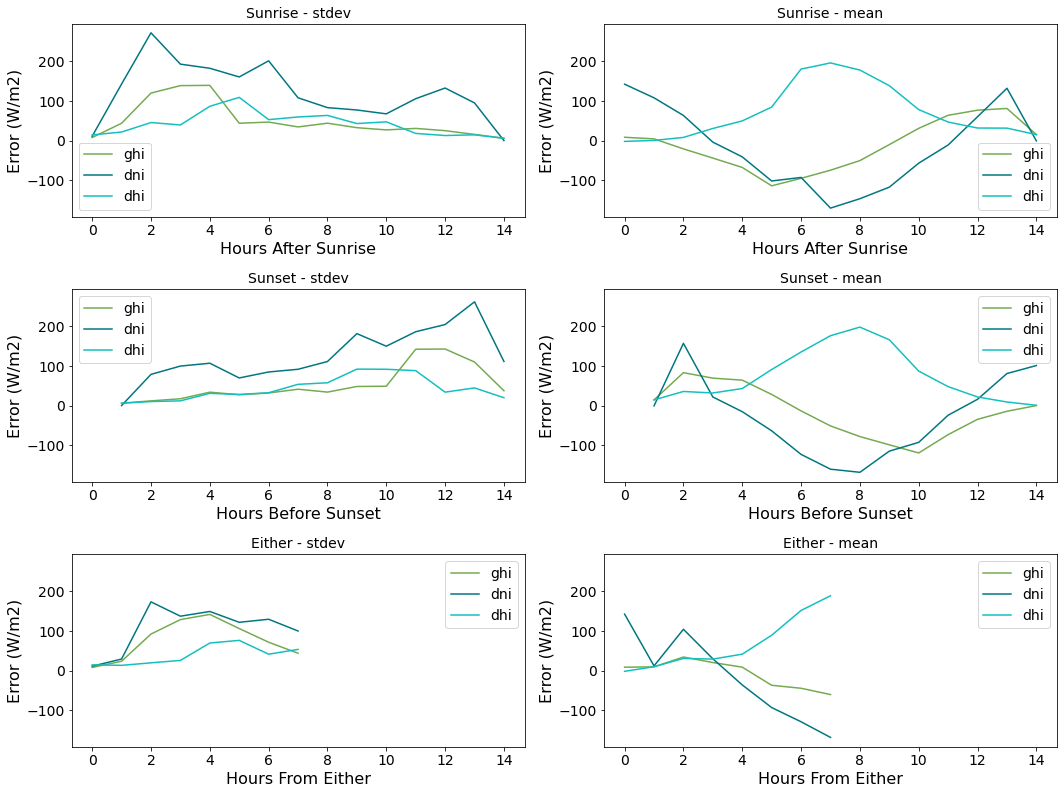

In [8]:
# Absolute error, W/m2

cases = [Statistics_Sunrise, Statistics_Sunset, Statistics_Either]

fig, axs = plt.subplots(len(cases), 2, figsize = (15, len(cases)*3.75), sharex=True, sharey=True)

row = 0
# for case in cases:

for column in Statistics_Sunrise.columns:
    if column.startswith('stdev'):
        column_index = 0
        title = 'stdev'
    else:
        column_index = 1
        title = 'mean'
        
    label = column.split('_')[-1]

    axs[row, column_index].plot(Statistics_Sunrise[column], label = label, color = colors[label])
    axs[row, column_index].legend()
    axs[row, column_index].set(xlabel = 'Hours After Sunrise', ylabel = 'Error (W/m2)')
    axs[row, column_index].set_title('Sunrise - ' + title)
    axs[row, column_index].tick_params(labelbottom=True)
    axs[row, column_index].tick_params(labelleft=True)    

row = 1
    
for column in Statistics_Sunset.columns:
    if column.startswith('stdev'):
        column_index = 0
        title = 'stdev'
    else:
        column_index = 1
        title = 'mean'
        
    label = column.split('_')[-1]

    axs[row, column_index].plot(Statistics_Sunset[column], label = label, color = colors[label])
    axs[row, column_index].legend()
    axs[row, column_index].set(xlabel = 'Hours Before Sunset', ylabel = 'Error (W/m2)')
    axs[row, column_index].set_title('Sunset - ' + title)
    axs[row, column_index].tick_params(labelbottom=True)
    axs[row, column_index].tick_params(labelleft=True)

row = 2

for column in Statistics_Either.columns:
    if column.startswith('stdev'):
        column_index = 0
        title = 'stdev'
    else:
        column_index = 1
        title = 'mean'
        
    label = column.split('_')[-1]

    axs[row, column_index].plot(Statistics_Either[column], label = label, color = colors[label])
    axs[row, column_index].legend()
    axs[row, column_index].set(xlabel = 'Hours From Either', ylabel = 'Error (W/m2)')
    axs[row, column_index].set_title('Either - ' + title)
    axs[row, column_index].tick_params(labelleft=True)

plt.tight_layout()
plt.show()

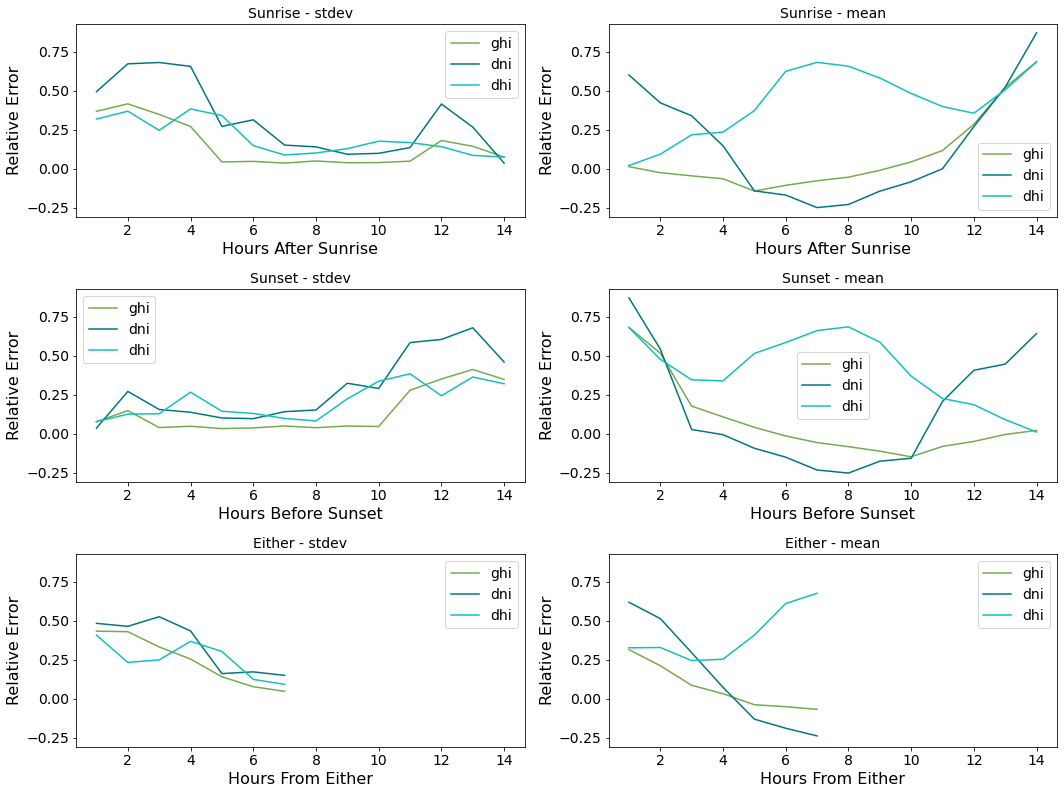

In [9]:
# Relative error

cases = [Statistics_Sunrise_Relative, Statistics_Sunset_Relative, Statistics_Either_Relative]

fig, axs = plt.subplots(len(cases), 2, figsize = (15, len(cases)*3.75), sharex=True, sharey=True)

row = 0
# for case in cases:

data = Statistics_Sunrise_Relative
for column in data.columns:
    if column.startswith('stdev'):
        column_index = 0
        title = 'stdev'
    else:
        column_index = 1
        title = 'mean'
        
    label = column.split('_')[-1]

    axs[row, column_index].plot(data[column][1:], label = label, color = colors[label])
    axs[row, column_index].legend()
    axs[row, column_index].set(xlabel = 'Hours After Sunrise', ylabel = 'Relative Error')
    axs[row, column_index].set_title('Sunrise - ' + title)
    axs[row, column_index].tick_params(labelbottom=True)
    axs[row, column_index].tick_params(labelleft=True)

row = 1

data = Statistics_Sunset_Relative
for column in data.columns:
    if column.startswith('stdev'):
        column_index = 0
        title = 'stdev'
    else:
        column_index = 1
        title = 'mean'
        
    label = column.split('_')[-1]

    axs[row, column_index].plot(data[column][:-1], label = label, color = colors[label])
    axs[row, column_index].legend()
    axs[row, column_index].set(xlabel = 'Hours Before Sunset', ylabel = 'Relative Error')
    axs[row, column_index].set_title('Sunset - ' + title)
    axs[row, column_index].tick_params(labelbottom=True)
    axs[row, column_index].tick_params(labelleft=True)

row = 2

data = Statistics_Either_Relative
for column in data.columns:
    if column.startswith('stdev'):
        column_index = 0
        title = 'stdev'
    else:
        column_index = 1
        title = 'mean'
        
    label = column.split('_')[-1]

    axs[row, column_index].plot(data[column][1:], label = label, color = colors[label])
    axs[row, column_index].legend()
    axs[row, column_index].set(xlabel = 'Hours From Either', ylabel = 'Relative Error')
    axs[row, column_index].set_title('Either - ' + title)
    axs[row, column_index].tick_params(labelleft=True)

plt.tight_layout()
plt.show()

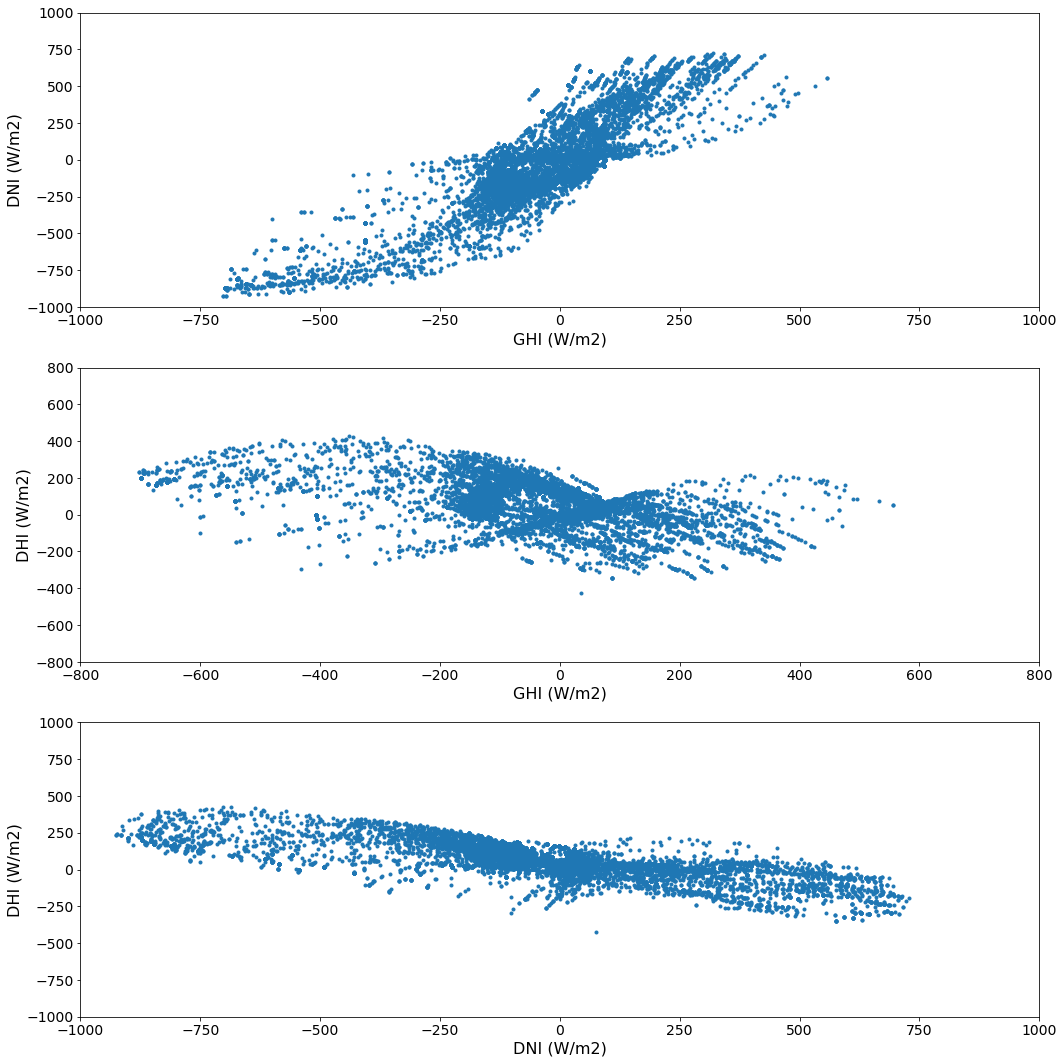

In [10]:
solar_error = full_data_set[['error_ghi', 'error_dni', 'error_dhi']].dropna()

fig, axs = plt.subplots(3, 1, figsize = (15, 3 * 5))

axs[0].plot(solar_error['error_ghi'], solar_error['error_dni'], marker = '.', linewidth = 0)
axs[0].set_xlim([-1000, 1000])
axs[0].set_ylim([-1000, 1000])
axs[0].set(xlabel = 'GHI (W/m2)', ylabel = 'DNI (W/m2)')
axs[1].plot(solar_error['error_ghi'], solar_error['error_dhi'], marker = '.', linewidth = 0)
axs[1].set_xlim([-800, 800])
axs[1].set_ylim([-800, 800])
axs[1].set(xlabel = 'GHI (W/m2)', ylabel = 'DHI (W/m2)')
axs[2].plot(solar_error['error_dni'], solar_error['error_dhi'], marker = '.', linewidth = 0)
axs[2].set_xlim([-1000, 1000])
axs[2].set_ylim([-1000, 1000])
axs[2].set(xlabel = 'DNI (W/m2)', ylabel = 'DHI (W/m2)')

plt.tight_layout()

In [11]:
# Notes
# - The correlation between error_ghi and error_dni is 0.86. Highly correlated
# - The correlation between dni and dhi is -0.77. Highly inversely correlated

correlation = solar_error.corr()
display(correlation)

,error_ghi,error_dni,error_dhi
error_ghi,1.000000,0.844791,-0.454145
error_dni,0.844791,1.000000,-0.733476
error_dhi,-0.454145,-0.733476,1.000000


In [12]:
from sklearn.metrics import r2_score

model_ghi = np.polyfit(solar_error['error_dni'], solar_error['error_ghi'], 2)
model_dhi = np.polyfit(solar_error['error_dni'], solar_error['error_dhi'], 1)

print('model_ghi is {}'.format(model_ghi))
print('model_dhi is {}'.format(model_dhi))

ghi = np.poly1d(model_ghi)
error_ghi = ghi(solar_error['error_dni'])
r2_ghi = r2_score(solar_error['error_ghi'], ghi(solar_error['error_dni']))
print('r2_ghi is {}'.format(r2_ghi))
pearson_squared_ghi = correlation.loc['error_ghi', 'error_dni']**2
print('pearson_squared_ghi is {}'.format(pearson_squared_ghi))

dhi = np.poly1d(model_dhi)
error_dhi = dhi(solar_error['error_dni'])
r2_dhi = r2_score(solar_error['error_dhi'], dhi(solar_error['error_dni']))
print('r2_dhi is {}'.format(r2_dhi))
pearson_squared_dhi = correlation.loc['error_dhi', 'error_dni']**2
print('pearson_squared_gdi is {}'.format(pearson_squared_dhi))

model_ghi is [-2.16624219e-04  4.49948484e-01  2.05835521e+00]
model_dhi is [-0.29066913 46.64875787]
r2_ghi is 0.7536129454960323
pearson_squared_ghi is 0.7136716536304823
r2_dhi is 0.5379870180105049
pearson_squared_gdi is 0.5379870180105033


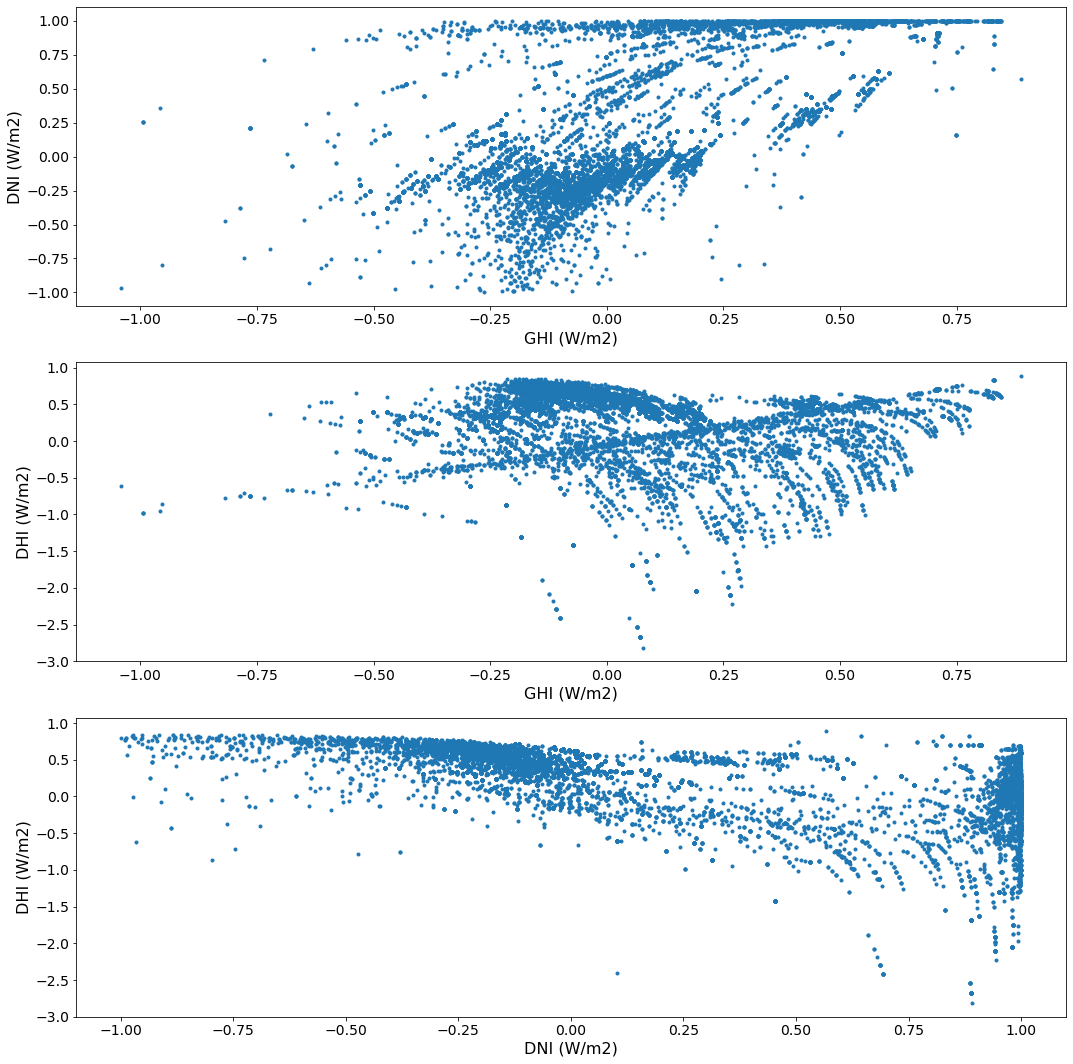

In [13]:
relative_solar_error = full_data_set[['relative_error_ghi', 'relative_error_dni', 'relative_error_dhi']].dropna()
relative_solar_error = relative_solar_error[relative_solar_error['relative_error_dni'] > -1]
# relative_solar_error = relative_solar_error[relative_solar_error['relative_error_dni'] < 0.99]

fig, axs = plt.subplots(3, 1, figsize = (15, 3 * 5))

axs[0].plot(relative_solar_error['relative_error_ghi'], relative_solar_error['relative_error_dni'], marker = '.', linewidth = 0)
# axs[0].set_xlim([-1000, 1000])
# axs[0].set_ylim([-1000, 1000])
axs[0].set(xlabel = 'GHI (W/m2)', ylabel = 'DNI (W/m2)')
axs[1].plot(relative_solar_error['relative_error_ghi'], relative_solar_error['relative_error_dhi'], marker = '.', linewidth = 0)
# axs[1].set_xlim([-800, 800])
# axs[1].set_ylim([-800, 800])
axs[1].set(xlabel = 'GHI (W/m2)', ylabel = 'DHI (W/m2)')
axs[2].plot(relative_solar_error['relative_error_dni'], relative_solar_error['relative_error_dhi'], marker = '.', linewidth = 0)
# axs[2].set_xlim([-1000, 1000])
# axs[2].set_ylim([-1000, 1000])
axs[2].set(xlabel = 'DNI (W/m2)', ylabel = 'DHI (W/m2)')

plt.tight_layout()

In [14]:
correlation_relative = relative_solar_error.corr()
display(correlation_relative)

,relative_error_ghi,relative_error_dni,relative_error_dhi
relative_error_ghi,1.000000,0.672093,-0.140565
relative_error_dni,0.672093,1.000000,-0.612338
relative_error_dhi,-0.140565,-0.612338,1.000000


In [15]:
# Create models estimating error in ghi and dhi based on dni

relative_model_ghi = np.polyfit(relative_solar_error['relative_error_dni'], relative_solar_error['relative_error_ghi'], 2)
relative_model_dhi = np.polyfit(relative_solar_error['relative_error_dni'], relative_solar_error['relative_error_dhi'], 1)

print('relative_model_ghi is {}'.format(relative_model_ghi))
print('relative_model_dhi is {}'.format(relative_model_dhi))

ghi = np.poly1d(relative_model_ghi)
error_ghi = ghi(relative_solar_error['relative_error_dni'])
r2_ghi = r2_score(relative_solar_error['relative_error_ghi'], ghi(relative_solar_error['relative_error_dni']))
print('r2_ghi is {}'.format(r2_ghi))
pearson_squared_ghi = correlation_relative.loc['relative_error_ghi', 'relative_error_dni']**2
print('pearson_squared_ghi is {}'.format(pearson_squared_ghi))

dhi = np.poly1d(relative_model_dhi)
error_dhi = dhi(relative_solar_error['relative_error_dni'])
r2_dhi = r2_score(relative_solar_error['relative_error_dhi'], dhi(relative_solar_error['relative_error_dni']))
print('r2_dhi is {}'.format(r2_dhi))
pearson_squared_dhi = correlation_relative.loc['relative_error_dhi', 'relative_error_dni']**2
print('pearson_squared_gdi is {}'.format(pearson_squared_dhi))

relative_model_ghi is [ 0.03427556  0.342067   -0.009031  ]
relative_model_dhi is [-0.6234402   0.35212069]
r2_ghi is 0.4524286662180549
pearson_squared_ghi is 0.4517090430978033
r2_dhi is 0.3749576659282827
pearson_squared_gdi is 0.37495766592828583


In [16]:
# Create model estimating error in dhi based on ghi

relative_model_dhi = np.polyfit(relative_solar_error['relative_error_ghi'], relative_solar_error['relative_error_dhi'], 1)

print('relative_model_dhi is {}'.format(relative_model_dhi))

dhi = np.poly1d(relative_model_dhi)
error_dhi = dhi(relative_solar_error['relative_error_ghi'])
r2_dhi = r2_score(relative_solar_error['relative_error_dhi'], dhi(relative_solar_error['relative_error_ghi']))
print('r2_dhi is {}'.format(r2_dhi))
pearson_squared_dhi = correlation_relative.loc['relative_error_dhi', 'relative_error_ghi']**2
print('pearson_squared_dhi is {}'.format(pearson_squared_dhi))

relative_model_dhi is [-0.2646598   0.26114893]
r2_dhi is 0.01975853980537856
pearson_squared_dhi is 0.019758539805378623


In [20]:
# Create model estimating error in dni based on ghi

relative_model_dni = np.polyfit(relative_solar_error['relative_error_ghi'], relative_solar_error['relative_error_dni'], 1)

print('relative_model_dni is {}'.format(relative_model_dni))

dhi = np.poly1d(relative_model_dni)
error_dni = dhi(relative_solar_error['relative_error_ghi'])
r2_dni = r2_score(relative_solar_error['relative_error_dni'], dhi(relative_solar_error['relative_error_ghi']))
print('r2_dni is {}'.format(r2_dni))
pearson_squared_dni = correlation_relative.loc['relative_error_dni', 'relative_error_ghi']**2
print('pearson_squared_dni is {}'.format(pearson_squared_dni))

relative_model_dni is [1.24290021 0.09767001]
r2_dni is 0.45170904309780324
pearson_squared_dni is 0.4517090430978033


In [ ]:
relative_error_coefficients = pd.DataFrame(index=['weaHGloHor', 'weaHDifHor'], columns = ['2nd order', '1st order', 'constant'])
# for coefficient in relative_model_ghi:
#     print(coefficient)
#     idx = np.where(relative_error_coefficients == coefficient)
#     print(idx)

for i in range(len(relative_model_ghi)):
    print(i)
    print(relative_model_ghi[i])
    relative_error_coefficients.iloc[0, i] = relative_model_ghi[i]
    
for i in range(len(relative_model_dhi)):
    print(i)
    print(relative_model_dhi[i])
    relative_error_coefficients.iloc[1, i+1] = relative_model_dhi[i]
    
relative_error_coefficients.iloc[1, 0] = 0
    
from IPython.display import display
display(relative_error_coefficients)

relative_error_coefficients.to_csv(r'C:\Users\Peter\Documents\MPC\ForecastAccuracy\Data\Filtered\Statistics\solar_coefficients_relative.csv')

In [ ]:
relative_solar_error.to_csv(r'C:\Users\Peter\Documents\MPC\ForecastAccuracy\solar_error_statistics.csv')

In [ ]:
# Perform these calcualtions instead in the noisy forecasts instead of in the measured data
# Consider how well that works
# Double check how pvlib handles daylight saving, see if that is causing errors
# ghi = dni * cos(zenith) + dhi

hourly_mean.index = hourly_mean.index.tz_localize(tz='America/Los_Angeles')
hourly_mean['zenith angle'] = pvlib.solarposition.ephemeris(hourly_mean.index, latitude, longitude)['zenith']
hourly_mean['dni-calc'] = pvlib.irradiance.dni(ghi=hourly_mean['ghi'], dhi=hourly_mean['dhi'], 
                                               zenith=hourly_mean['zenith angle'])

indices = [3, 27, 51, 75, 99, 123, 147, 171, 195, 219, 243, 267, 291, 315, 339, 363, 387]

for index in indices:
    timestamp = hourly_mean.index[index]
    print(timestamp)
    month = timestamp.month
    day = timestamp.day

    test = hourly_mean[hourly_mean.index.month == month]
    test = test[test.index.day == day]

    test[['ghi', 'dhi', 'dni', 'dni-calc']].plot()